# "아침"시간대 유동인구의 주기(Cycle) 성분 예측

## 1. import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

# 상위 폴더에서 module을 import하기 위해 시스템 경로에 상위 폴더의 경로를 추가
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

## 2. 데이터불러오기

In [2]:
### morning data
with open('../data/preprocess/m_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

#print(data_list[1].shape)
data_list = append_cycle_size(data_list)
#print(data_list[1].shape)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

## 3. 모델 불러오기

In [3]:
# load model
model = LSTMModel_cycle(input_size = 12, hidden_size = 32, no_time_size = 4).to(device)
# set model
criterion = nn.MSELoss(size_average = True)


train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}
start_epochs = 0
num_epochs = 0

## 4. 훈련

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-2)

run_epochs = 400
num_epochs += run_epochs
for t in range(start_epochs, num_epochs):
    train_pred = model(train_time, train_notime)
    loss = criterion(train_pred, train_y[:,:,1])
    train_error.append(loss)
    valid_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, 'models/best_cycles.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

start_epochs = num_epochs
best_model = torch.load('models/best_cycles.pkl')

10 Epochs train MSE: 0.17452 // valid MSE: 0.14136
20 Epochs train MSE: 0.08365 // valid MSE: 0.07467
30 Epochs train MSE: 0.08063 // valid MSE: 0.07312
40 Epochs train MSE: 0.07657 // valid MSE: 0.06970
50 Epochs train MSE: 0.07570 // valid MSE: 0.07021
60 Epochs train MSE: 0.07474 // valid MSE: 0.06883
70 Epochs train MSE: 0.07406 // valid MSE: 0.06820
80 Epochs train MSE: 0.07305 // valid MSE: 0.06768
90 Epochs train MSE: 0.07160 // valid MSE: 0.06695
100 Epochs train MSE: 0.06918 // valid MSE: 0.06560
110 Epochs train MSE: 0.06547 // valid MSE: 0.06366
120 Epochs train MSE: 0.06062 // valid MSE: 0.06179
130 Epochs train MSE: 0.04949 // valid MSE: 0.05817
140 Epochs train MSE: 0.04259 // valid MSE: 0.05643
150 Epochs train MSE: 0.03920 // valid MSE: 0.05504
160 Epochs train MSE: 0.03487 // valid MSE: 0.05300
170 Epochs train MSE: 0.02895 // valid MSE: 0.04823
180 Epochs train MSE: 0.02231 // valid MSE: 0.04457
190 Epochs train MSE: 0.01748 // valid MSE: 0.04154
200 Epochs train MSE:

## 5. 훈련 결과

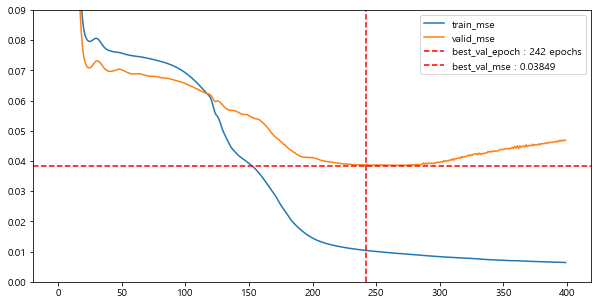

In [5]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32

plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.axvline(hist['best_val_epoch'],
             color = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.axhline(hist['best_val_error'],
             color = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.09)
plt.show()

In [5]:
best_model = torch.load('models/best_cycles.pkl')

In [6]:
# trend
i = 1
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

morning trend
zeros error :  0.073460214
random normal error :  1.0718024


In [7]:
print("morning cycle results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,1]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,1]))

morning cycle results
train_error :  tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0385, device='cuda:0', grad_fn=<MseLossBackward>)


In [8]:
# cycle
i = 1
print("morning cycle")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

morning cycle
zeros error :  0.073460214
random normal error :  1.0677294


## 6. 훈련 데이터와 검증 데이터의 성능 비교

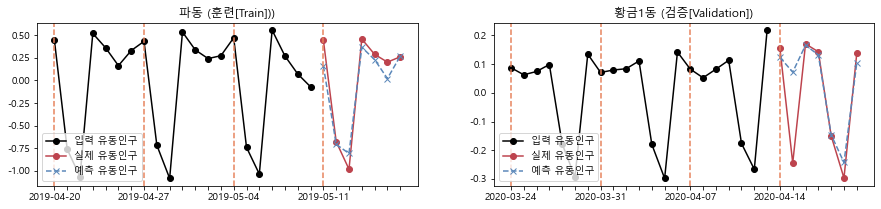

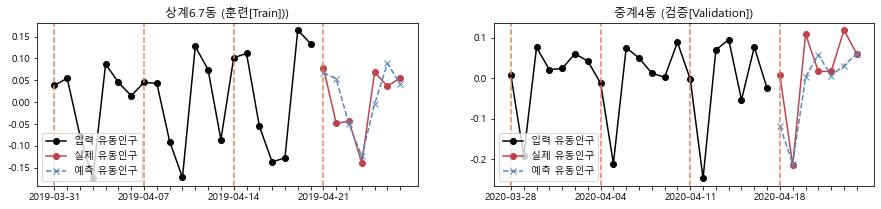

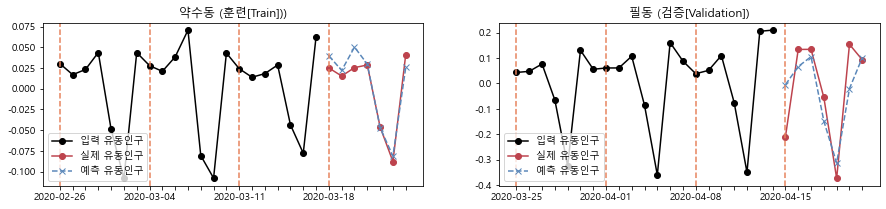

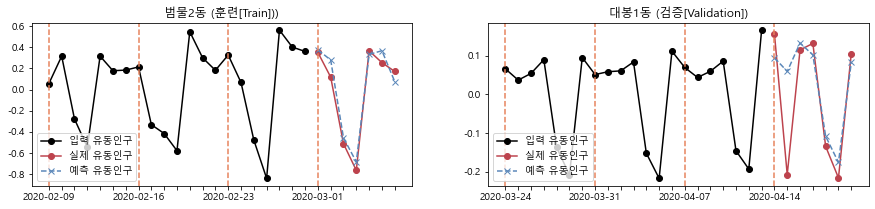

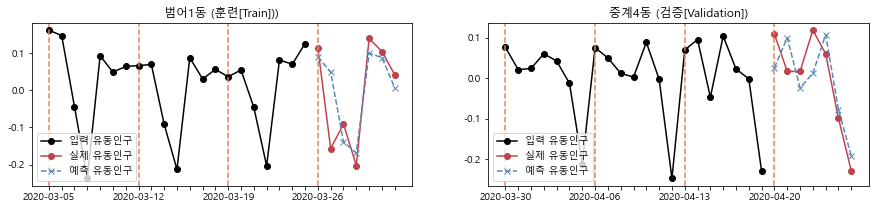

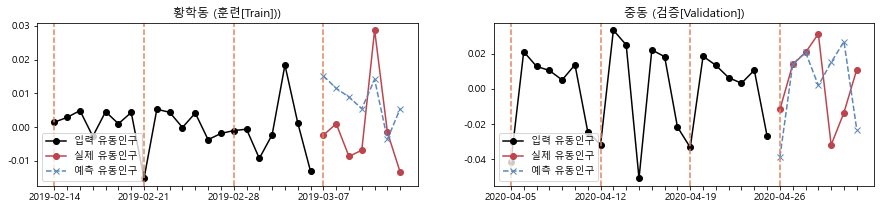

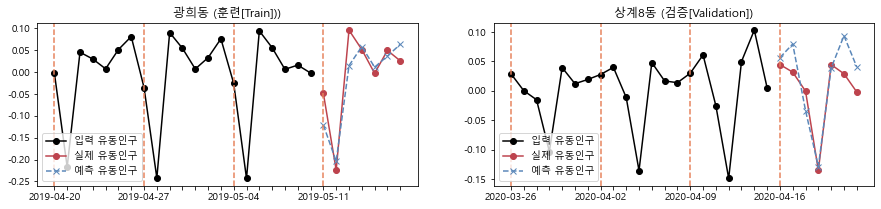

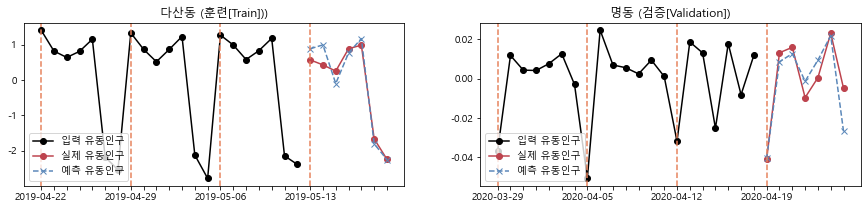

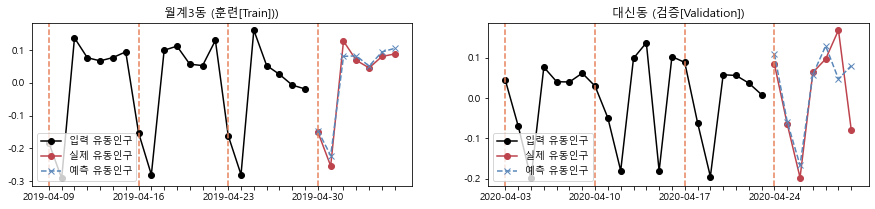

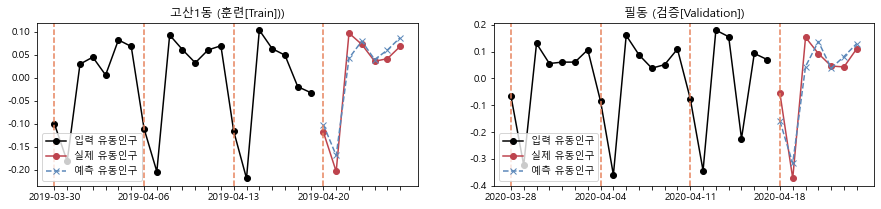

In [10]:
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = '../data/train_results/morning_results/'
with open(path + 'm_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

## 7. 평가(test set)

In [9]:
test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,1]))

test_error :  tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward>)


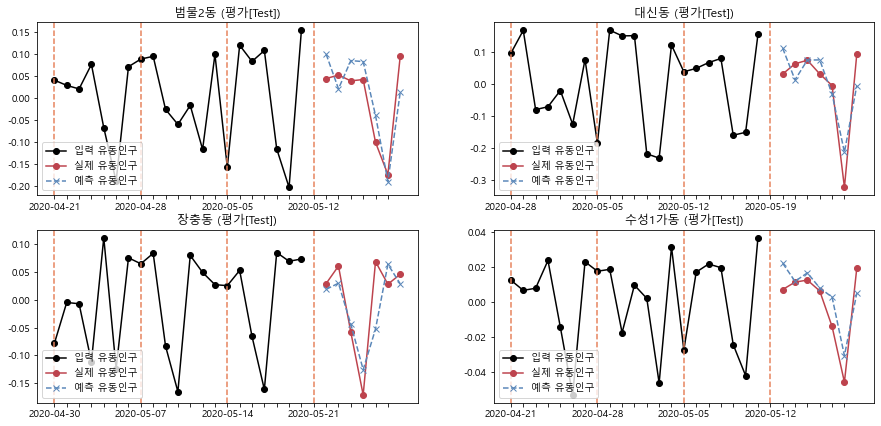

In [9]:
test_pred = best_model(test_time, test_notime)

# convert result
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([test_time[:,:,-1], test_y[:,:,1], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_result_list = [test_time_x_np, test_y_np, test_pred_np]

path = '../data/train_results/morning_results/'
with open(path + 'm_cycle_results_test.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

## 8. 6월 유동인구 주기(Cycle) 성분 예측

In [10]:
with open('../data/preprocess/june_data/morning_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/preprocess/june_data/morning_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

tc = 1
cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
pred_y = best_model(train_time_x, train_notime_x)
pred_y = np.array(pred_y.cpu().detach())

path = '../data/predict_june/predict_cycle_trend/'
with open(path + 'june_morning_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)